--- 1. Chargement du jeu de données Online Retail ---

📌 Aperçu des 5 premières lignes du DataFrame:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

📌 Informations sur les types de données et les valeurs non nulles:
<class 'pandas.core.frame.DataFrame'>
RangeI

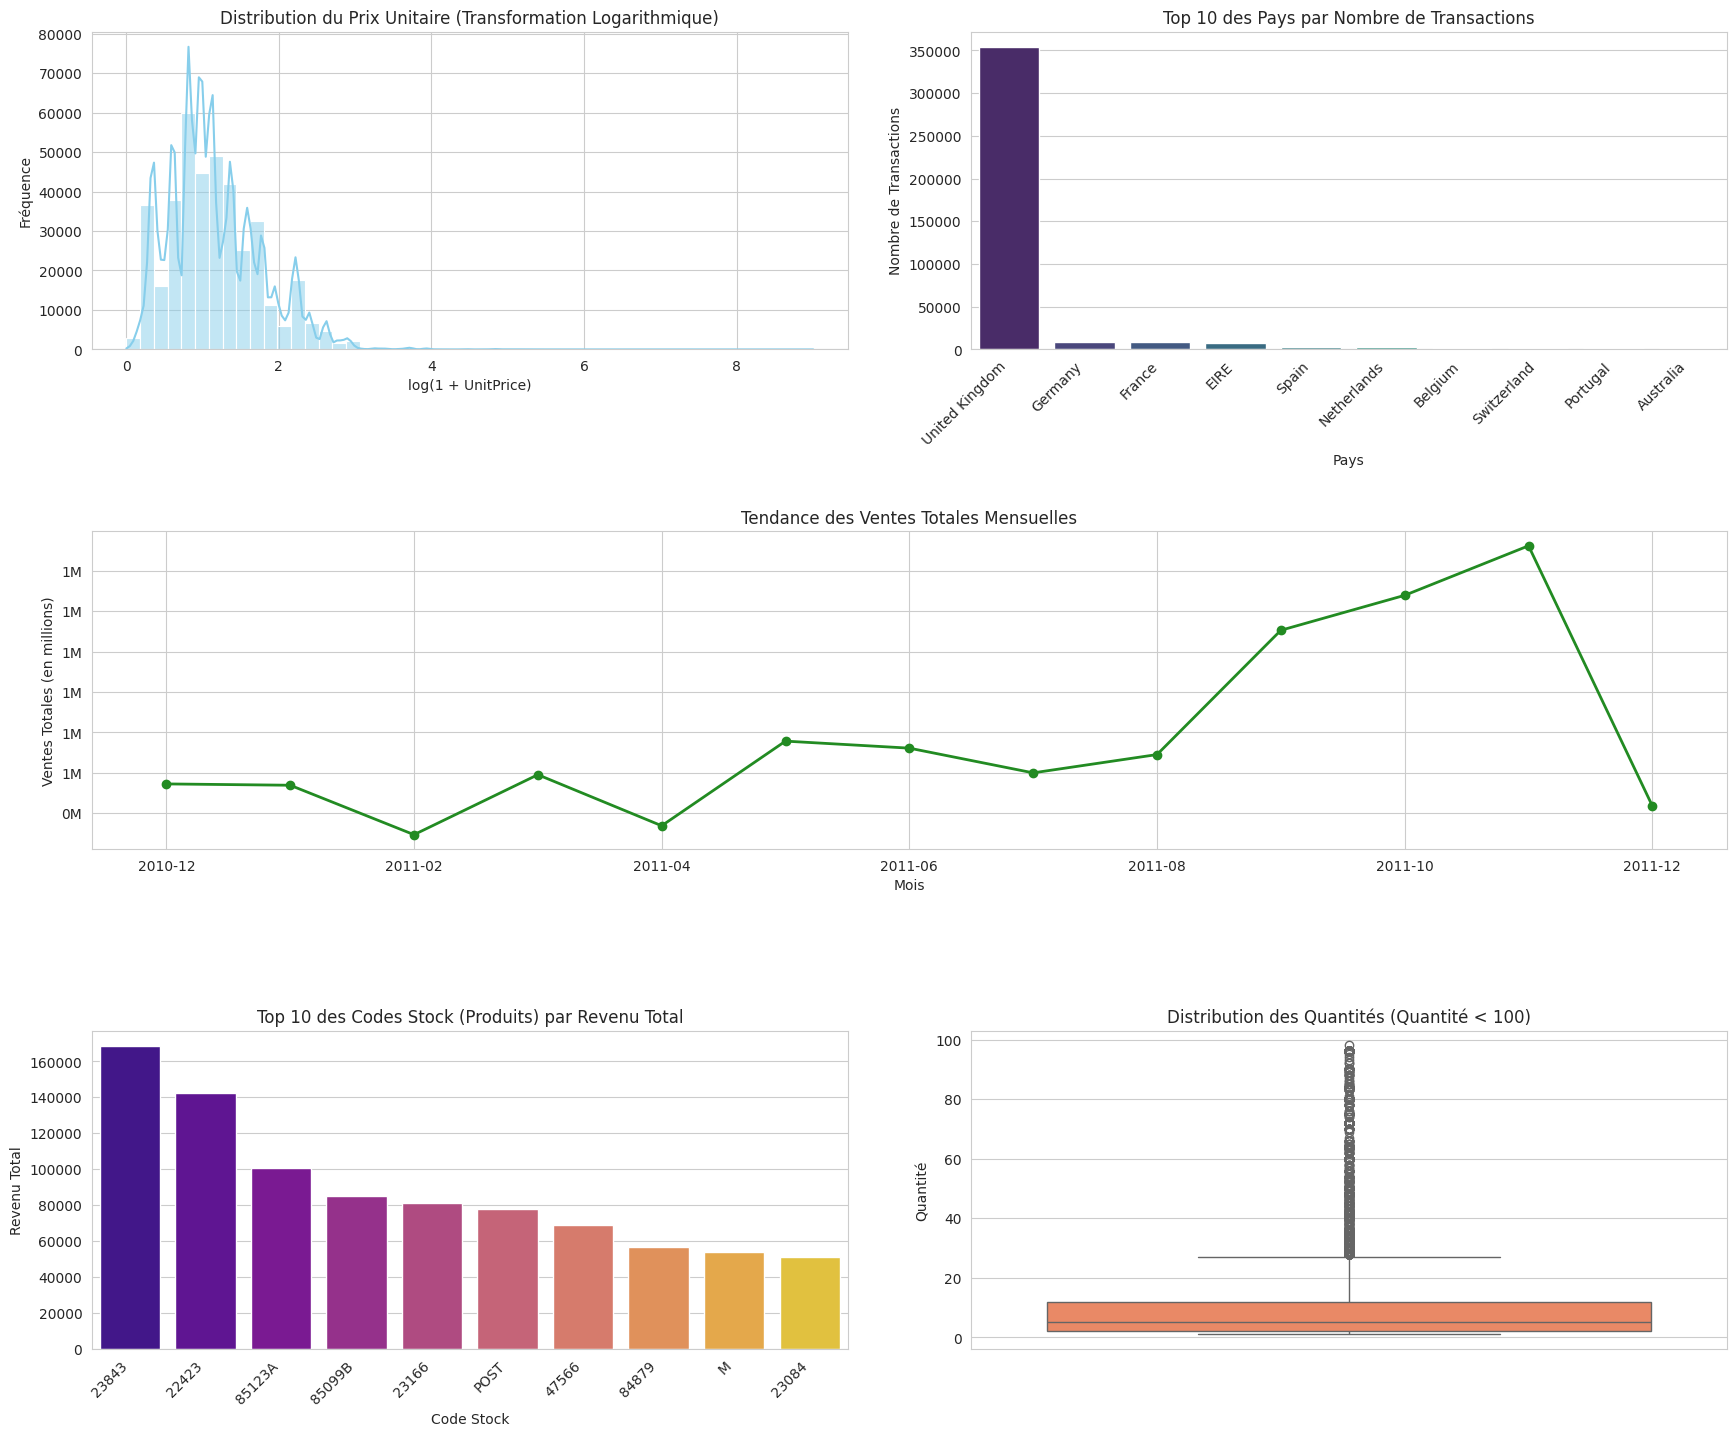


--- 4. Informations Clés (Post-Nettoyage) ---
Période de temps couverte : 2010-12-01 à 2011-12-09
Nombre total de clients uniques : 4338
Revenu total (après nettoyage) : £8,911,407.90


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from matplotlib.ticker import FuncFormatter # Import FuncFormatter

# --- 1. Chargement et inspection des données ---
print("--- 1. Chargement du jeu de données Online Retail ---")
# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
df = online_retail.data.original.copy() # Load the full original dataset
# The 'Target' column is often not present in the raw Online Retail dataset
# and was added as None in the original code, causing no functional benefit.
# We will remove it unless a specific prediction task requires it later.
# Note: The 'Online Retail' dataset is often used for Association Rule Mining (like Apriori) or RFM analysis,
# so we'll primarily focus on the features.

# Affichage des premières lignes et des types de données
print("\n📌 Aperçu des 5 premières lignes du DataFrame:")
print(df.head())
print("\n📌 Informations sur les types de données et les valeurs non nulles:")
df.info()

# --- 2. Nettoyage et préparation des données ---

# Convertir InvoiceDate en datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Supprimer les lignes avec des valeurs manquantes dans StockCode et CustomerID
# C'est crucial pour l'analyse client (RFM)
df.dropna(subset=['StockCode', 'CustomerID'], inplace=True)

# S'assurer que Quantity et UnitPrice sont positifs pour l'analyse des ventes
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Calculer le montant total de la transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("\n--- 2. Résumé après nettoyage et calcul de TotalPrice ---")
print(f"Nombre de lignes après nettoyage : {len(df)}")
print(df[['Quantity', 'UnitPrice', 'TotalPrice']].describe().T)

# --- 3. Analyse et Visualisations Clés ---

# Définir le style des graphiques
sns.set_style("whitegrid")
plt.figure(figsize=(18, 15))

# --- Graphique 1: Distribution des prix unitaires (log-transformé) ---
plt.subplot(3, 2, 1)
# Utiliser log1p pour gérer la forte asymétrie
sns.histplot(np.log1p(df['UnitPrice']), bins=50, kde=True, color='skyblue')
plt.title('Distribution du Prix Unitaire (Transformation Logarithmique)')
plt.xlabel('log(1 + UnitPrice)')
plt.ylabel('Fréquence')

# --- Graphique 2: Top 10 des pays par nombre de transactions ---
plt.subplot(3, 2, 2)
top_countries = df['Country'].value_counts().nlargest(10)
sns.barplot(x=top_countries.index, y=top_countries.values, hue=top_countries.index, palette='viridis', legend=False)
plt.title('Top 10 des Pays par Nombre de Transactions')
plt.xlabel('Pays')
plt.ylabel('Nombre de Transactions')
plt.xticks(rotation=45, ha='right')

# --- Graphique 3: Montant total des ventes au fil du temps (par mois) ---
plt.subplot(3, 1, 2)
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum()
monthly_sales.index = monthly_sales.index.astype(str) # Convert PeriodIndex to string for plotting
monthly_sales.plot(kind='line', marker='o', color='forestgreen', linewidth=2)
plt.title('Tendance des Ventes Totales Mensuelles')
plt.xlabel('Mois')
plt.ylabel('Ventes Totales (en millions)')

# Re-formater les étiquettes de l'axe y pour une meilleure lisibilité (par ex. en millions) using FuncFormatter
def millions_formatter(x, pos):
    return '{:,.0f}M'.format(x / 1_000_000)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
# Removed plt.ticklabel_format and manual set_yticklabels as FuncFormatter handles it.

# --- Graphique 4: Top 10 des produits (StockCode) par revenu total ---
plt.subplot(3, 2, 5)
top_products = df.groupby('StockCode')['TotalPrice'].sum().nlargest(10).sort_values(ascending=False)
sns.barplot(x=top_products.index, y=top_products.values, hue=top_products.index, palette='plasma', legend=False)
plt.title('Top 10 des Codes Stock (Produits) par Revenu Total')
plt.xlabel('Code Stock')
plt.ylabel('Revenu Total')
plt.xticks(rotation=45, ha='right')

# --- Graphique 5: Distribution des quantités vendues ---
plt.subplot(3, 2, 6)
# Limiter l'axe x pour une meilleure visualisation (ignorer les très grandes quantités)
sns.boxplot(y=df[df['Quantity'] < 100]['Quantity'], color='coral')
plt.title('Distribution des Quantités (Quantité < 100)')
plt.ylabel('Quantité')

plt.tight_layout(pad=3.0)
plt.show()

# --- 4. Informations Complémentaires Clés ---
print("\n--- 4. Informations Clés (Post-Nettoyage) ---")
print(f"Période de temps couverte : {df['InvoiceDate'].min().strftime('%Y-%m-%d')} à {df['InvoiceDate'].max().strftime('%Y-%m-%d')}")
print(f"Nombre total de clients uniques : {df['CustomerID'].nunique()}")
print(f"Revenu total (après nettoyage) : £{df['TotalPrice'].sum():,.2f}")